### **BERT**

#### **BERT** is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

In [43]:
  from google.colab import files
  uploaded = files.upload()

Saving bert.png to bert.png


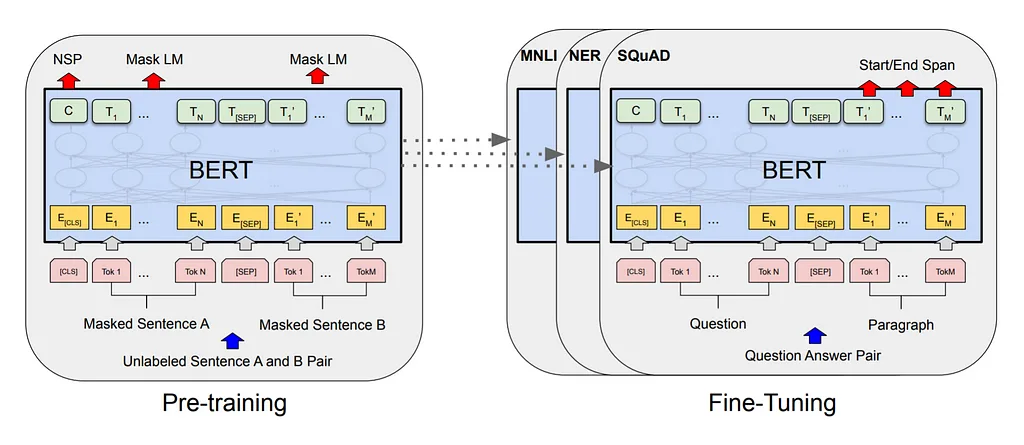

In [44]:
from IPython import display
display.Image('bert.png',width=900)

In [1]:
!pip install tensorflow-gpu >> /dev/null

ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.5.0 which is incompatible.


In [2]:
!pip install sentencepiece >> /dev/null

### **Downloading one of the simpler pre-trained model**

In [3]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2021-05-19 11:46:39--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   166MB/s    in 2.3s    

2021-05-19 11:46:41 (166 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



### **Unzip Pre-Trained Model**

In [4]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [6]:
import os

### **Create Newfolder as model & Save pre-Trained model**

In [7]:
os.makedirs("model", exist_ok=True)

### **Move Pre-Trained model to the model folder**

In [8]:
!mv uncased_L-12_H-768_A-12/ model

In [9]:

import os
import math
import datetime

import pandas as pd 
import numpy as np

#Ploting usages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
import seaborn as sns
from pylab import rcParams
%matplotlib inline

#Tensorflow framework
import tensorflow as tf
from tensorflow import keras

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
# Read the dataset
train_url="https://raw.githubusercontent.com/KrishArul26/Data_set/main/Disaster_Tweet_train.csv"
data=pd.read_csv(train_url,sep=",")

In [ ]:
!pip install bert-for-tf2

In [13]:
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

### **Specify the Model name**

In [14]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

### **Preprocessing**

We need to convert the texts into vectors. Then only we can feed into our BERT model.Whic preprocessing steps are:

Tokenize the text
Convert the sequence of tokens into numbers
Pading the sequences

In [15]:
!pip install tqdm 

In [16]:
from tqdm import tqdm

In [17]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
#Drop keyword,Id and location
data=data.iloc[:,3:5]

In [19]:
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### **Train-Test Split**

In [21]:
from sklearn import model_selection
#splitting the data (80:20 ratio)
train,test=model_selection.train_test_split(data,test_size=0.2,random_state=100)

In [22]:
print("Training data set independent features contain " + " " + str(len(train))+ " "+ "Observation")
print("Testing data set contain  " + " " + str(len(test))+ " "+ "Observation")

Training data set independent features contain  6090 Observation
Testing data set contain   1523 Observation


### **Padding**

In [23]:
class target_classification:
  text_column = "text"
  target_column = "target"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[target_classification.text_column].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, target = row[target_classification.text_column], row[target_classification.target_column]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(target))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [24]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [25]:
sentence="Natural language processing (NLP) is the intersection of computer science, linguistics and machine learning. The field focuses on communication between computers and humans in natural language and NLP is all about making computers understand and generate human language"
tokens=tokenizer.tokenize(sentence)


In [26]:
tokenizer.convert_tokens_to_ids(tokens)

[3019,
 2653,
 6364,
 1006,
 17953,
 2361,
 1007,
 2003,
 1996,
 6840,
 1997,
 3274,
 2671,
 1010,
 15397,
 1998,
 3698,
 4083,
 1012,
 1996,
 2492,
 7679,
 2006,
 4807,
 2090,
 7588,
 1998,
 4286,
 1999,
 3019,
 2653,
 1998,
 17953,
 2361,
 2003,
 2035,
 2055,
 2437,
 7588,
 3305,
 1998,
 9699,
 2529,
 2653]

### **Fine-tuning BERT model**

In [27]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

### **Training The Model**

In [28]:
classes = train.target.unique().tolist()

data = target_classification(train, test, tokenizer, classes, max_seq_len=128)

6090it [00:03, 1666.61it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
1523it [00:00, 1798.54it/s]


max seq_len 84


In [29]:
print("After tokenization and padding train_x shape is"+str( data.train_x.shape))
print("After tokenization and padding train_y shape is"+str( data.train_y.shape))
print("After tokenization and padding test_x shape is"+str( data.train_x.shape))
print("After tokenization and padding test_y shape is"+str( data.train_y.shape))

After tokenization and padding train_x shape is(6090, 84)
After tokenization and padding train_y shape is(6090,)
After tokenization and padding test_x shape is(6090, 84)
After tokenization and padding test_y shape is(6090,)


In [30]:
data.train_x[0]

array([ 101, 2919, 2154,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

### **Creating the BERT model**

In [31]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 84, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f1250430ad0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 84)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 84, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1538  

In [33]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [34]:
# log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=2
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


343/343 [==============================] - 5586s 16s/step - loss: 0.5821 - acc: 0.7126 - val_loss: 0.4595 - val_acc: 0.7833


In [35]:
import pickle
model.save('/content/drive/My Drive/bert_model_disaster_tweet')

INFO:tensorflow:Assets written to: /content/drive/My Drive/bert_model_disaster_tweet/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/bert_model_disaster_tweet/assets


### Evaluation

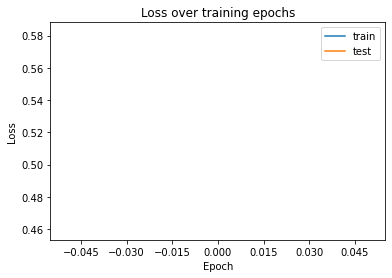

In [36]:
# %load_ext tensorboard
# %tensorboard --logdir log
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [37]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

48/48 [==============================] - 440s 9s/step - loss: 0.3918 - acc: 0.8339
train acc 0.8502463102340698
test acc 0.8338804841041565


In [38]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [39]:
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


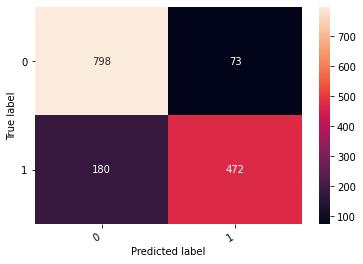

In [42]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');